<a href="https://colab.research.google.com/github/muchofamuchness/v2/blob/master/hw3_t11902102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization & Pre_processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import metrics
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torch.utils.data as tud
import plotly.graph_objects as go
import plotly.express as px
import datetime
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

In [2]:
#df_news = pd.read_csv(r"/content/drive/MyDrive/Fintech/news_list.csv")
df_impr = pd.read_json(r"/content/drive/MyDrive/Fintech/impression_v3.json")

In [3]:
df_impr['full_input'] = df_impr.loc[:, 'click_seq_10_onehot']
for i in range(df_impr.shape[0]):
  df_impr.loc[i,'full_input'].append(df_impr.loc[i,'target_news_onehot'])

In [ ]:
# make the target_news_onehot --> category 0-18, day 0-6 
'''
for i in range(df_impr.shape[0]):
  for j in range(0,19):
    if df_impr.loc[i,'target_news_onehot'][j] == 1:
      df_impr.loc[i,'target_news_category'] = j
      break
  for j in range(19,27):
    if df_impr.loc[i,'target_news_onehot'][j] == 1:
      df_impr.loc[i,'target_news_publish_day'] = j-19
      break

df_impr.set_index('target_news_category','target_news_publish_day','y')
'''

In [4]:
days = [g for n, g in df_impr.groupby(pd.Grouper(key='impression_time',freq='D'))]

train_days = []
for i in range(7): train_days.append(days[i])
train = pd.concat(train_days)

validate_days = []
for i in range(7,9): validate_days.append(days[i])
validate = pd.concat(validate_days)

test = days[9].copy()

#  Click Prediction Model

In [5]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features):
        self.features = features
        self.target = target
        self.y = torch.tensor(dataframe[target].values).float()
        self.x = torch.tensor(np.stack(dataframe[features].values)).float()

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i): 
        return self.x[i], self.y[i]

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
features = 'full_input'
len_features = len(df_impr['full_input'][0][0])
target = 'y'
batch_size = 30

In [7]:
train_dataset = SequenceDataset(
    dataframe=train,
    target = target,
    features = features,
)

val_dataset = SequenceDataset(
    validate,
    target = target,
    features = features,
)

test_dataset = SequenceDataset(
    test,
    target = target,
    features = features,
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

x, y = next(iter(train_loader))

# Balance Dataframe

In [8]:
# creating a balances dataset
df_pressed = df_impr.loc[df_impr['y'] == 1].copy()
df_not_pressed = df_impr.loc[df_impr['y'] == 0].copy()

b_size = df_pressed.shape[0]

all_frames = [df_pressed[:b_size], df_not_pressed[:b_size]]
df_balanced = pd.concat(all_frames).sample(frac = 1) # concat and shuffle
print(f"df balanced: {df_balanced.shape}")

train_balanced = df_balanced[:b_size].copy()
test_balanced = df_balanced[b_size:].copy()
print(f"train balanced: {train_balanced.shape}")
print(f"test balanced: {test_balanced.shape}")

train_dataset_balanced = SequenceDataset(
    train_balanced,
    target = target,
    features = features,
)

test_dataset_balanced = SequenceDataset(
    test_balanced,
    target = target,
    features = features,
)

train_loader_balanced = DataLoader(train_dataset_balanced, batch_size=batch_size, shuffle=True)
test_loader_balanced = DataLoader(test_dataset_balanced, batch_size=batch_size, shuffle=False)
x_balanced, y_balanced = next(iter(train_loader_balanced))

df balanced: (3038, 9)
train balanced: (1519, 9)
test balanced: (1519, 9)


# For debug

In [ ]:
# for debugging!!!

train_ex = df_impr.iloc[0:60].copy()
test_ex = df_impr.iloc[60:120].copy()

train_dataset_ex = SequenceDataset(
    train_ex,
    target = target,
    features = features,
)

test_dataset_ex = SequenceDataset(
    test_ex,
    target = target,
    features = features,
)

train_loader_ex = DataLoader(train_dataset_ex, batch_size=batch_size, shuffle=True)
test_loader_ex = DataLoader(test_dataset_ex, batch_size=batch_size, shuffle=False)
x_ex, y_ex = next(iter(train_loader))

# Train & Test functions

In [10]:
def train_model(data_loader, model, loss_function, optimizer):
    total_loss = 0
    model.train()
    
    for x, y in data_loader:
        y_pred = model(x.to(device))
        y = y.to(device)
        loss = loss_function(y_pred, y.unsqueeze(1)) # unsqueeze so its 2D not 1D
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    avg_loss = total_loss / len(data_loader) # this is the number of batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function, output_list):
    total_loss = 0
    model.eval()
    y_pred = torch.Tensor().to(device)
    y_true = torch.Tensor().to(device)
    with torch.no_grad():
        for x, y in data_loader:
            y = y.to(device)
            output = model(x.to(device))
            total_loss += loss_function(output, y.unsqueeze(1)).item()
            threshold = torch.tensor([0.5]).to(device)
            out_bin = (output>threshold).float()*1
            y_pred = torch.cat((y_pred, out_bin),0)
            y_true = torch.cat((y_true, y),0)
            output_list.append(output)

    #accuracy = torch.eq(y_pred,y).float().mean()
    avg_loss = total_loss / len(data_loader) # this is the number of batches
    print(f"Test loss: {avg_loss}")
    return avg_loss, y_pred, y_true #accuracy.item()

#  Bidirectional-LSTM 

In [11]:
class BiLSTM_Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(BiLSTM_Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True) # set to true
        self.fc = nn.Linear(hidden_size * 2, output_size)# mul hid size by 2
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden_state = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).requires_grad_() # mul num layers by 2
        cell_state = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).requires_grad_() # mul num layers by 2
        out, h = self.lstm(x.to(device), (hidden_state.to(device), cell_state.to(device)))
        out = self.fc(out[:,-1,:]) #out = self.fc(h[0]).flatten()
        out = torch.sigmoid(out)
        return out

In [12]:
bilstm_model = BiLSTM_Model(input_size=len_features, output_size=1, hidden_size=15, num_layers=2) # 2 layers
bilstm_model.to(device)
num_epochs = 100
lr=0.0001
loss_function = nn.BCELoss()
criterion = nn.BCELoss() # nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=lr)

In [13]:
# for debugging with balanced dataframe

test_model(test_loader_balanced, bilstm_model, loss_function,[])
epoch_loss = [list(range(num_epochs)),[],[]]
epoch_accu = []
for cur_epoch in range(num_epochs):
    print(f"----- epoch num: {cur_epoch} -----")
    cur_output = []
    train_loss = train_model(train_loader_balanced, bilstm_model, loss_function, optimizer=optimizer)
    val_loss, y_pred, y_true= test_model(test_loader_balanced, bilstm_model, loss_function,cur_output)
    y_pred = y_pred[:,0]
    #accuracy = torch.eq(y_pred,y_true).float().mean()
    #print(f"accuracy 1: {accuracy} -----")
    bilstm_accuracy = sklearn.metrics.accuracy_score(y_true.cpu(), y_pred.cpu())
    print(f"accuracy: {bilstm_accuracy} -----")
    epoch_loss[1].append(train_loss)
    epoch_loss[2].append(val_loss)
    epoch_accu.append(bilstm_accuracy.item())
    final_outputs = cur_output if cur_epoch == num_epochs - 1 else []

Test loss: 0.6928010582923889
----- epoch num: 0 -----
Train loss: 0.6931954972884234
Test loss: 0.6923779915360844
accuracy: 0.5121790651744569 -----
----- epoch num: 1 -----
Train loss: 0.6925354483080846
Test loss: 0.6919899688047522
accuracy: 0.5806451612903226 -----
----- epoch num: 2 -----
Train loss: 0.6918928810194427
Test loss: 0.6913337017975602
accuracy: 0.6425279789335089 -----
----- epoch num: 3 -----
Train loss: 0.691052471890169
Test loss: 0.6904038950508716
accuracy: 0.6938775510204082 -----
----- epoch num: 4 -----
Train loss: 0.6898664399689319
Test loss: 0.6891364688966789
accuracy: 0.6905859117840685 -----
----- epoch num: 5 -----
Train loss: 0.6879953765401653
Test loss: 0.6868169050590665
accuracy: 0.7057274522712311 -----
----- epoch num: 6 -----
Train loss: 0.684858129304998
Test loss: 0.6821973744560691
accuracy: 0.7425938117182357 -----
----- epoch num: 7 -----
Train loss: 0.6787830789883932
Test loss: 0.6742385766085457
accuracy: 0.7327188940092166 -----
----

In [ ]:
# real code
test_model(val_loader, bilstm_model, loss_function,[])
epoch_loss_lstm = [list(range(num_epochs)),[],[]]
epoch_accu_lstm = []

for cur_epoch in range(num_epochs):
    print(f"----- epoch num: {cur_epoch} -----")
    cur_output_lstm = []
    train_loss = train_model(train_loader, bilstm_model, loss_function, optimizer=optimizer)
    val_loss, val_accu = test_model(val_loader, bilstm_model, loss_function,cur_output_lstm)

    epoch_loss_lstm[1].append(train_loss)
    epoch_loss_lstm[2].append(val_loss)
    epoch_accu_lstm.append(val_accu)
    final_outputs_lstm = cur_output_lstm if cur_epoch == num_epochs - 1 else []

# (iii) Training loss and validation loss Plot

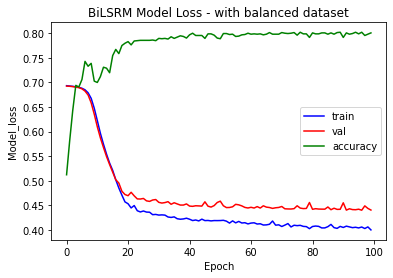

In [15]:
plt.plot(
    epoch_loss[0], 
    epoch_loss[1],
    color="blue",
    label="train",
)
plt.plot(
    epoch_loss[0], 
    epoch_loss[2],
    color="red",
    label="val",
)

plt.plot(
    epoch_loss[0], 
    epoch_accu,
    color="green",
    label="accuracy",
)

plt.legend()
plt.xlabel('Epoch') 
plt.ylabel('Model_loss') 
plt.title('BiLSRM Model Loss - with balanced dataset') 
plt.show() 

# (iv) AUROC and PRC plot

In [16]:
bilstm_accuracy = sklearn.metrics.accuracy_score(y_true.cpu(), y_pred.cpu())
bilstm_precision = sklearn.metrics.precision_score(y_true.cpu(), y_pred.cpu())
bilstm_recall = sklearn.metrics.recall_score(y_true.cpu(), y_pred.cpu())
print(bilstm_accuracy)
print(bilstm_precision)
print(bilstm_recall)

0.8005266622778143
0.9489603024574669
0.6452442159383034


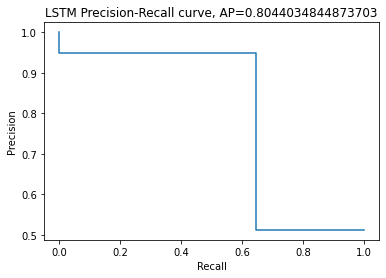

In [17]:
precision_lstm, recall_lstm, _ = precision_recall_curve(y_true.cpu(), y_pred.cpu())
display_lr = PrecisionRecallDisplay(
    recall = recall_lstm,
    precision = precision_lstm)
display_lr.plot()
auc_lr = metrics.roc_auc_score(y_true.cpu(), y_pred.cpu())
_ = display_lr.ax_.set_title("LSTM Precision-Recall curve, AP={}".format(auc_lr))

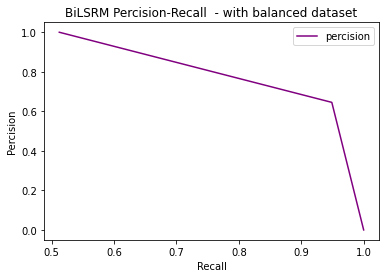

In [18]:
plt.plot(
    precision_lstm, 
    recall_lstm,
    color="purple",
    label="percision",
)
plt.legend()
plt.xlabel('Recall') 
plt.ylabel('Percision') 
plt.title('BiLSRM Percision-Recall  - with balanced dataset') 
plt.show() 

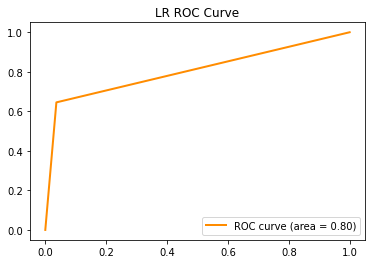

In [19]:
fpr, tpr, thresholds = metrics.roc_curve(y_true.cpu(), y_pred.cpu(), pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.title("LR ROC Curve")
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.legend(loc='lower right')


# (v) Bidirectional-GRU

In [102]:
def train_model(data_loader, model, loss_function, optimizer):
    total_loss = 0
    model.train()
    
    for x, y in data_loader:
        y_pred = model(x.to(device))
        y = y.to(device)
        loss = loss_function(y_pred, y.unsqueeze(1)) # unsqueeze so its 2D not 1D
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    avg_loss = total_loss / len(data_loader) # this is the number of batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function, output_list):
    total_loss = 0
    model.eval()
    y_pred = torch.Tensor().to(device)
    y_true = torch.Tensor().to(device)
    with torch.no_grad():
        for x, y in data_loader:
            y = y.to(device)
            output = model(x.to(device))
            print(f"shape check output: {output.shape}")
            print(f"shape check y: {y.shape}")
            total_loss += loss_function(output, y).item() #.unsqueeze(1)
            threshold = torch.tensor([0.5]).to(device)
            out_bin = (output>threshold).float()*1
            y_pred = torch.cat((y_pred, out_bin),0)
            y_true = torch.cat((y_true, y),0)
            output_list.append(output)

    #accuracy = torch.eq(y_pred,y).float().mean()
    avg_loss = total_loss / len(data_loader) # this is the number of batches
    print(f"Test loss: {avg_loss}")
    return avg_loss, y_pred, y_true #accuracy.item()

In [138]:
class BiGRU_Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, drop_prob=0.2):
        super(BiGRU_Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=drop_prob, bidirectional=True) # set to true
        self.fc = nn.Linear(hidden_size * 2, output_size)# mul hid size by 2
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden_state = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).requires_grad_() # mul num layers by 2
        #cell_state = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).requires_grad_() # mul num layers by 2
        _, h = self.gru(x.to(device), (hidden_state.to(device)))
        print(h.shape)
        out = self.fc(h[0,0])#.flatten() #out = self.fc(h[0]).flatten() [:,-1,:] [0,:,0] worked a bit
        print(f"out shape: {out.shape}")
        #out = torch.sigmoid(out)
        return h

In [139]:
bigru_model = BiGRU_Model(input_size=len_features, output_size=1, hidden_size=15, num_layers=2) # 2 layers
bigru_model.to(device)
num_epochs = 10
lr=0.0001
loss_function = nn.BCELoss()
criterion = nn.BCELoss() # nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bigru_model.parameters(), lr=lr)

In [140]:
test_model(test_loader_balanced, bigru_model, loss_function,[])

torch.Size([4, 30, 15])


RuntimeError: ignored

In [ ]:
# for debugging with balanced dataframe
test_model(test_loader_balanced, bigru_model, loss_function,[])
epoch_loss = [list(range(num_epochs)),[],[]]
epoch_accu = []
for cur_epoch in range(num_epochs):
    print(f"----- epoch num: {cur_epoch} -----")
    cur_output = []
    train_loss = train_model(train_loader_balanced, bigru_model, loss_function, optimizer=optimizer)
    val_loss, y_pred, y_true= test_model(test_loader_balanced, bigru_model, loss_function,cur_output)
    y_pred = y_pred[:,0]
    bilstm_accuracy = sklearn.metrics.accuracy_score(y_true.cpu(), y_pred.cpu())
    print(f"accuracy: {bilstm_accuracy} -----")
    epoch_loss[1].append(train_loss)
    epoch_loss[2].append(val_loss)
    epoch_accu.append(bilstm_accuracy.item())
    final_outputs = cur_output if cur_epoch == num_epochs - 1 else []